Create 3 sub DataFrames from the h5 file, monofil, quare, likelihood

In [1]:
import pandas as pd
import numpy as np
h5_path = r"C:\Python Programming\LIU\hrnet_w48_2024_11_18\1-1_convertedDLC_HrnetW48_hrnet_w48_2Nov18shuffle1_snapshot_100.h5"
df = pd.read_hdf(h5_path)
df.columns = [f"{bodypart}_{coord}" for bodypart, coord in zip(df.columns.get_level_values(1), df.columns.get_level_values(2))]
df_monofil = df.loc[:, df.columns.str.startswith(('FR', 'FG', 'FB')) & ~df.columns.str.endswith('likelihood')]
df_square = df.loc[:, df.columns.str.startswith(('Top_left', 'Top_right', 'Bottom_left', 'Bottom_right')) & ~df.columns.str.endswith('likelihood')]
df_likelihoods = df.loc[:, df.columns.str.endswith('likelihood')]
overall_average = df_likelihoods.mean().mean()
print("Overall Average Likelihood:", overall_average)
bodypart_means = df_likelihoods.mean(axis=0)
print("Mean likelihood for each body part:")
print(bodypart_means)


Overall Average Likelihood: 0.9325193
Mean likelihood for each body part:
FR1_likelihood             0.894157
FR2_likelihood             0.984162
FG1_likelihood             0.835096
FG2_likelihood             0.865367
FB1_likelihood             0.889174
FB2_likelihood             0.970239
Top_left_likelihood        0.934921
Top_right_likelihood       0.981655
Bottom_left_likelihood     0.983718
Bottom_right_likelihood    0.986704
dtype: float32


Fill missing values

In [2]:
df_monofil.interpolate(method='linear', inplace=True)
df_square.interpolate(method='linear', inplace=True)
print(df_monofil.isna().sum())
print(df_square.isna().sum())

FR1_x    0
FR1_y    0
FR2_x    0
FR2_y    0
FG1_x    0
FG1_y    0
FG2_x    0
FG2_y    0
FB1_x    0
FB1_y    0
FB2_x    0
FB2_y    0
dtype: int64
Top_left_x        0
Top_left_y        0
Top_right_x       0
Top_right_y       0
Bottom_left_x     0
Bottom_left_y     0
Bottom_right_x    0
Bottom_right_y    0
dtype: int64


C:\Users\Gabri\AppData\Local\Temp\ipykernel_3844\293690190.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monofil.interpolate(method='linear', inplace=True)
C:\Users\Gabri\AppData\Local\Temp\ipykernel_3844\293690190.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_square.interpolate(method='linear', inplace=True)


Create bending_coeficcient, calculate the peaks and plot

C:\Users\Gabri\AppData\Local\Temp\ipykernel_3844\1220050329.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monofil["Bending_Coefficient"] = bending_coefficients


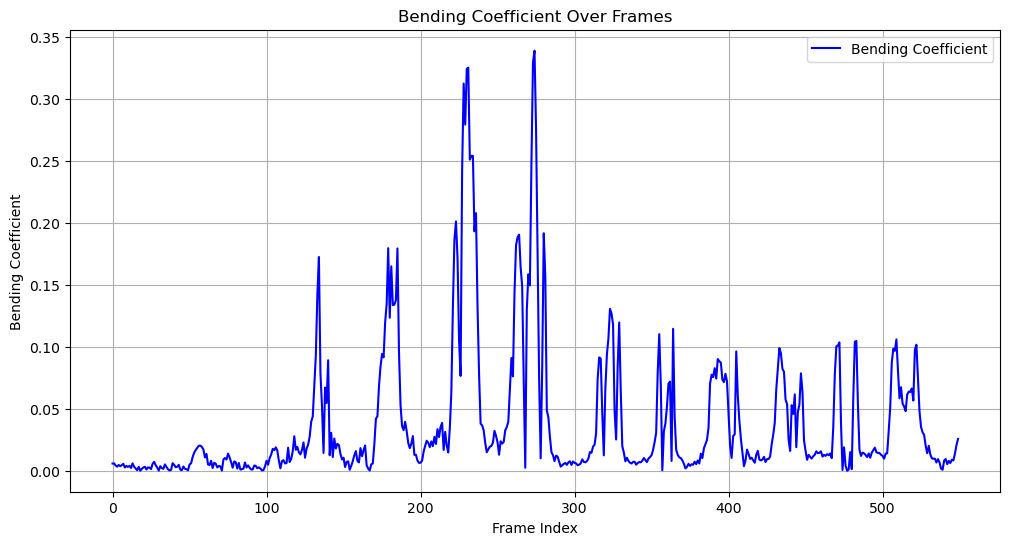

NameError: name 'negative_peaks' is not defined

In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Assuming df_monofil is already loaded with monofilament data

# Initialize a list to store bending coefficients
bending_coefficients = []

# Process each row of df_monofil
for index, row in df_monofil.iterrows():
    # Step 1: Extract x and y coordinates for the current row
    x_coords = row.filter(like="_x").values
    y_coords = row.filter(like="_y").values

    # Step 2: Center coordinates around their mean
    x_centered = x_coords - np.mean(x_coords)
    y_centered = y_coords - np.mean(y_coords)

    # Step 3: Fit a polynomial (degree 2)
    degree = 2
    coefficients = np.polyfit(x_centered, y_centered, degree)
    bending_coeff = coefficients[0]  # Coefficient of the quadratic term

    # Store the bending coefficient for this frame
    bending_coefficients.append(abs(bending_coeff))

# Step 4: Add the bending coefficients as a new column in df_monofil
df_monofil["Bending_Coefficient"] = bending_coefficients

# Create Threshhold for peaks at 14% of the maxiumum values
max_val = df_monofil['Bending_Coefficient'].max()
threshold = 0.14 * max_val  #! threshold, potential input % value

# Step 5: Plot the bending coefficients
plt.figure(figsize=(12, 6))
plt.plot(df_monofil.index, df_monofil["Bending_Coefficient"], label="Bending Coefficient", color="blue")
plt.title("Bending Coefficient Over Frames")
plt.xlabel("Frame Index")
plt.ylabel("Bending Coefficient")
plt.grid(True)
plt.legend()
plt.show()

frame_distance = 20 #! potential input value

# Step 6: Detect peaks in the bending coefficient column
positive_peaks, _ = find_peaks(df_monofil["Bending_Coefficient"], height=threshold, distance=frame_distance)

# Combine both
all_peaks = np.sort(np.concatenate((positive_peaks, negative_peaks)))

# Step 7: Overlay peaks on the bending coefficient plot
plt.figure(figsize=(12, 6))
plt.plot(df_monofil.index, df_monofil["Bending_Coefficient"], label="Bending Coefficient", color="blue")
plt.scatter(all_peaks, df_monofil["Bending_Coefficient"].iloc[all_peaks], color="red", label="Peaks")
plt.title("Bending Coefficient with Detected Peaks")
plt.xlabel("Frame Index")
plt.ylabel("Bending Coefficient")
plt.grid(True)
plt.legend()
plt.show()

# Step 8: Display peak indices and values
peak_values = df_monofil["Bending_Coefficient"].iloc[all_peaks]
print("Detected Peaks:")
print(peak_values)
print(f"Total nr of peaks: {len(peak_values)}")

3 point bending coefficient calculation, not as good as the polynomial fit

FR1_x                  0
FR1_y                  0
FR2_x                  0
FR2_y                  0
FG1_x                  0
FG1_y                  0
FG2_x                  0
FG2_y                  0
FB1_x                  0
FB1_y                  0
FB2_x                  0
FB2_y                  0
Bending_Coefficient    0
dtype: int64
Top_left_x        0
Top_left_y        0
Top_right_x       0
Top_right_y       0
Bottom_left_x     0
Bottom_left_y     0
Bottom_right_x    0
Bottom_right_y    0
dtype: int64


C:\Users\Gabri\AppData\Local\Temp\ipykernel_21540\1806292923.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_monofil.interpolate(method='linear', inplace=True)
C:\Users\Gabri\AppData\Local\Temp\ipykernel_21540\1806292923.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_square.interpolate(method='linear', inplace=True)
C:\Users\Gabri\AppData\Local\Temp\ipykernel_21540\1806292923.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

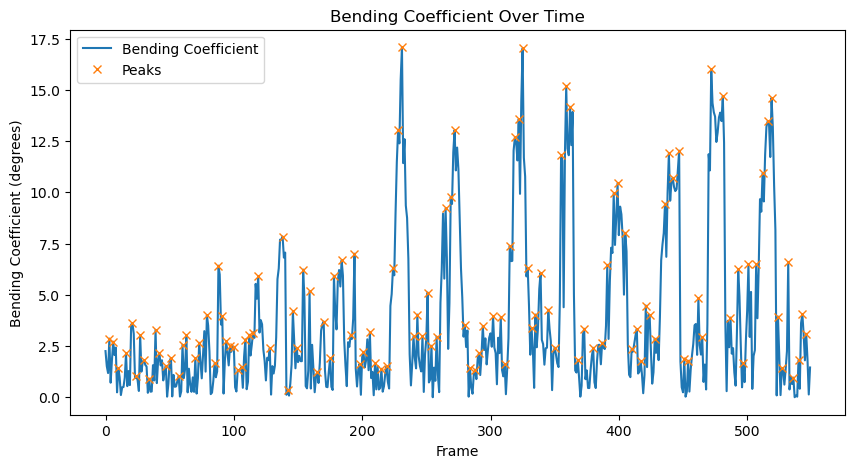

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Assuming df_monofil and df_square are already defined and loaded

# Interpolate missing values
df_monofil.interpolate(method='linear', inplace=True)
df_square.interpolate(method='linear', inplace=True)

# Check for any remaining missing values
print(df_monofil.isna().sum())
print(df_square.isna().sum())

# Calculate the bending coefficient using 3 points (FR1, FR2, FG1)
def calculate_bending_coefficient(df):
    A = np.column_stack((df['FR1_x'], df['FR1_y']))
    B = np.column_stack((df['FR2_x'], df['FR2_y']))
    C = np.column_stack((df['FG1_x'], df['FG1_y']))

    AB = B - A
    BC = C - B
    dot_product = np.einsum('ij,ij->i', AB, BC)
    magnitude_AB = np.linalg.norm(AB, axis=1)
    magnitude_BC = np.linalg.norm(BC, axis=1)
    angle_radians = np.arccos(dot_product / (magnitude_AB * magnitude_BC))
    bending_coefficients = np.degrees(angle_radians)

    return bending_coefficients

# Calculate bending coefficients
bending_coefficients = calculate_bending_coefficient(df_monofil)
df_monofil["Bending_Coefficient"] = bending_coefficients

# Find peaks in the bending coefficients
peaks, _ = find_peaks(df_monofil["Bending_Coefficient"], height=0.2, distance=3)

# Plot the bending coefficients and peaks
plt.figure(figsize=(10, 5))
plt.plot(df_monofil["Bending_Coefficient"], label='Bending Coefficient')
plt.plot(peaks, df_monofil["Bending_Coefficient"][peaks], 'x', label='Peaks')
plt.xlabel('Frame')
plt.ylabel('Bending Coefficient (degrees)')
plt.title('Bending Coefficient Over Time')
plt.legend()
plt.show()

In [4]:
import numpy as np
import pandas as pd
import cv2

# Assuming df_square and df_monofil are your DataFrames
# df_square = pd.read_csv('path_to_your_square_dataframe.csv')  # Load your DataFrame if not already loaded
# df_monofil = pd.read_csv('path_to_your_monofil_dataframe.csv')  # Load your DataFrame if not already loaded

# Function to apply homography and center the square
def apply_homography(df_square, df_monofil):
    frames = []
    transformed_monofil_points = []

    for i in range(len(df_square)):
        # Extract points for the current frame
        src_points = np.array([
            [df_square.iloc[i]['Top_left_x'], df_square.iloc[i]['Top_left_y']],
            [df_square.iloc[i]['Top_right_x'], df_square.iloc[i]['Top_right_y']],
            [df_square.iloc[i]['Bottom_right_x'], df_square.iloc[i]['Bottom_right_y']],
            [df_square.iloc[i]['Bottom_left_x'], df_square.iloc[i]['Bottom_left_y']]
        ], dtype=np.float32)

        # Define destination points (centered square)
        dst_points = np.array([
            [100, 100],
            [200, 100],
            [200, 200],
            [100, 200]
        ], dtype=np.float32)

        # Compute homography matrix
        H, _ = cv2.findHomography(src_points, dst_points)

        # Create a blank image
        frame = np.zeros((300, 300, 3), dtype=np.uint8)

        # Apply homography to the square points
        warped_frame = cv2.warpPerspective(frame, H, (300, 300))

        # Draw the centered square
        cv2.polylines(warped_frame, [np.int32(dst_points)], isClosed=True, color=(0, 255, 0), thickness=1)

        # Extract monofilament points for the current frame
        monofil_points = np.array([
            [df_monofil.iloc[i]['FR1_x'], df_monofil.iloc[i]['FR1_y']],
            [df_monofil.iloc[i]['FR2_x'], df_monofil.iloc[i]['FR2_y']],
            [df_monofil.iloc[i]['FG1_x'], df_monofil.iloc[i]['FG1_y']],
            [df_monofil.iloc[i]['FG2_x'], df_monofil.iloc[i]['FG2_y']],
            [df_monofil.iloc[i]['FB1_x'], df_monofil.iloc[i]['FB1_y']],
            [df_monofil.iloc[i]['FB2_x'], df_monofil.iloc[i]['FB2_y']]
        ], dtype=np.float32)

        # Apply homography to the monofilament points
        monofil_points_transformed = cv2.perspectiveTransform(monofil_points.reshape(-1, 1, 2), H).reshape(-1, 2)
        # Store the transformed points
        transformed_monofil_points.append(monofil_points_transformed.flatten())

        # Draw the transformed monofilament points
        for point in monofil_points_transformed:
            cv2.circle(warped_frame, (int(point[0]), int(point[1])), 2, (255, 0, 0), -1)

        # Append the frame to the list
        frames.append(warped_frame)

    # Convert the list of transformed points to a DataFrame
    columns = ['tf_FR1_x', 'tf_FR1_y', 'tf_FR2_x', 'tf_FR2_y', 'tf_FG1_x', 'tf_FG1_y', 'tf_FG2_x', 'tf_FG2_y', 'tf_FB1_x', 'tf_FB1_y', 'tf_FB2_x', 'tf_FB2_y']
    df_transformed_monofil = pd.DataFrame(transformed_monofil_points, columns=columns)

    return frames, df_transformed_monofil

# Function to save frames as a video
def save_video(frames, output_path, fps=30):
    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 file
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    for frame in frames:
        out.write(frame)

    out.release()

# Apply homography to center the square and transform monofilament points
frames, transformed_monofil = apply_homography(df_square, df_monofil)

# Save the result as a video
save_video(frames, 'centered_square_with_monofil.mp4')
print("Video saved as 'centered_square_with_monofil.mp4'")

Video saved as 'centered_square_with_monofil.mp4'


In [5]:
transformed_monofil

,tf_FR1_x,tf_FR1_y,tf_FR2_x,tf_FR2_y,tf_FG1_x,tf_FG1_y,tf_FG2_x,tf_FG2_y,tf_FB1_x,tf_FB1_y,tf_FB2_x,tf_FB2_y
0,119.150597,-215.211288,130.693909,-131.890289,137.516098,-93.857697,142.091797,-56.355942,149.913422,-1.200479,154.006378,48.949833
1,117.932480,-229.399124,130.042419,-140.474747,136.514160,-100.717468,142.794876,-60.508316,149.804871,-3.182292,153.677567,45.701393
2,119.418930,-226.583008,131.123749,-137.467529,136.778015,-100.362144,142.111771,-60.590687,150.400787,-2.588371,153.672745,46.591793
3,114.627853,-232.062973,126.990578,-141.623764,134.362396,-102.171204,139.646393,-61.555061,148.753799,-3.488219,153.206558,46.931240
4,112.404976,-246.398788,126.492043,-149.221268,132.944305,-108.180031,140.101608,-65.415169,148.825348,-5.658854,152.825897,45.756779
...,...,...,...,...,...,...,...,...,...,...,...,...
545,116.319084,-85.277100,136.244064,-0.340657,144.883484,32.466808,151.647949,64.540390,157.940582,104.490120,164.313370,137.953812
546,118.318207,-85.700943,137.745865,2.705334,146.020737,33.472931,151.948486,64.270287,157.831650,105.509308,164.514954,139.240753
547,116.896790,-79.808197,137.651169,3.369738,146.611374,35.434586,153.634323,66.508362,158.773270,106.752098,164.669601,141.241013
548,116.880112,-81.640663,140.034241,2.183156,149.204254,35.641003,155.804626,65.991875,159.532303,106.256683,165.186890,142.047470


## Read in Nerve Data

In [6]:
file_path = r"C:\Python Programming\LIU\nerve accel data\RFMapping_Unit_4_before-inflammation.xlsx"
df_nerve = pd.read_excel(file_path)
df_nerve.tail()

,Time,Spikes nw-1-01,16 Comments,5 Accelerometer,Unnamed: 4,Comments (1 in column C)
104141,104.141,0,0,1.781107,NaN,NaN
104142,104.142,0,0,1.781620,NaN,NaN
104143,104.143,0,0,1.782132,NaN,NaN
104144,104.144,0,0,1.782645,NaN,NaN
104145,NaN,116,4,NaN,NaN,NaN


In [7]:
# slice the columns, keep only "Spikes nw-1-01" and "5 Accelerometer" and "Time"
df_nerve = df_nerve.loc[:, ["Spikes nw-1-01", "5 Accelerometer", "Time"]]
df_nerve.columns = ["Spikes", "Accelerometer", "Time"]
df_nerve.dropna(inplace=True, subset=["Spikes", "Accelerometer", "Time"])
df_nerve.tail()

,Spikes,Accelerometer,Time
104140,0,1.780595,104.140
104141,0,1.781107,104.141
104142,0,1.781620,104.142
104143,0,1.782132,104.143
104144,0,1.782645,104.144


C:\Users\Gabri\AppData\Local\Temp\ipykernel_3844\608828239.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_nerve["IFF"].fillna(method='ffill', inplace=True) # fill the NaN values with the previous non-NaN value
C:\Users\Gabri\AppData\Local\Temp\ipykernel_3844\608828239.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_nerve["IFF"].fillna(method='ffill', inplace=True) # fill the NaN values with the previous non-NaN value
C:\Us

<Axes: >

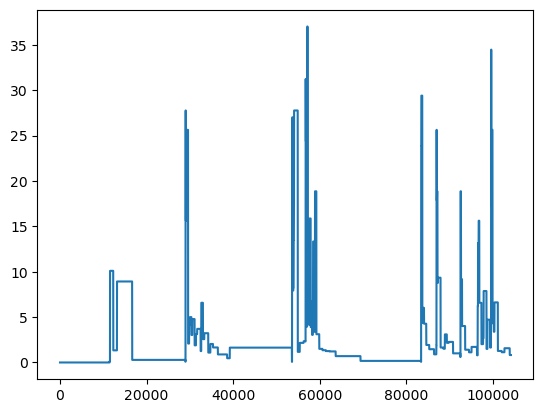

In [11]:
# Create Instantaneous Frequency Firing (IFF), reciprocal to the length of neuron interspike time interval

# 1 divided by the difference between the current time and last spike time
spikes_loc = df_nerve[df_nerve["Spikes"] == 1].index
spikes_loc

df_nerve["IFF"] = np.nan

for i in range(1, len(spikes_loc)):
    diff = df_nerve.loc[spikes_loc[i], "Time"] - df_nerve.loc[spikes_loc[i - 1], "Time"] # calculate the difference between the current time and last spike time
    df_nerve.loc[spikes_loc[i], "IFF"] = 1 / diff # calculate the reciprocal of the difference

df_nerve["IFF"].fillna(method='ffill', inplace=True) # fill the NaN values with the previous non-NaN value
df_nerve["IFF"].fillna(0, inplace=True) # fill the NaN values with the previous non-NaN value

df_nerve["IFF"].plot()

In [ ]:
import numpy as np
import pandas as pd

def downsample_binary_df(df, original_freq, target_freq):
    # Calculate the downsampling factor
    downsample_factor = int(original_freq / target_freq)

    # Apply a rolling window with a maximum function to preserve binary components
    downsampled_df = df.rolling(window=downsample_factor, min_periods=1).max()
    
    #! Take max of IFF
    #! Take sum of Spikes/Neuron

    # Downsample the DataFrame by selecting every downsample_factor-th row
    downsampled_df = downsampled_df.iloc[::downsample_factor]

    return downsampled_df

# Example usage
# Assuming df is your input DataFrame with a sampling rate of 1000Hz
original_freq = 1000
target_freq = 30
downsampled_df = downsample_binary_df(df_nerve, original_freq, target_freq)

In [19]:
len(df_nerve)

104145

In [20]:
len(downsampled_df)

3156

In [12]:
downsampled_df["Spikes"].sum()

116.0

In [32]:
downsampled_df["Time"]

0           0.000
33          0.033
66          0.066
99          0.099
132         0.132
           ...   
103983    103.983
104016    104.016
104049    104.049
104082    104.082
104115    104.115
Name: Time, Length: 3156, dtype: float64

### Plot accelerometer data

In [62]:
# get dv_nerve for after the first 82 seconds on the Time column

df_nerve[df_nerve["Time"] > 82].head()

,Spikes,Accelerometer,Time,IFF
82001,0,1.963624,82.001,0.174307
82002,0,1.962399,82.002,0.174307
82003,0,1.961174,82.003,0.174307
82004,0,1.959949,82.004,0.174307
82005,0,1.958724,82.005,0.174307


C:\Users\Gabri\AppData\Local\Temp\ipykernel_27848\2982199848.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15, 6))


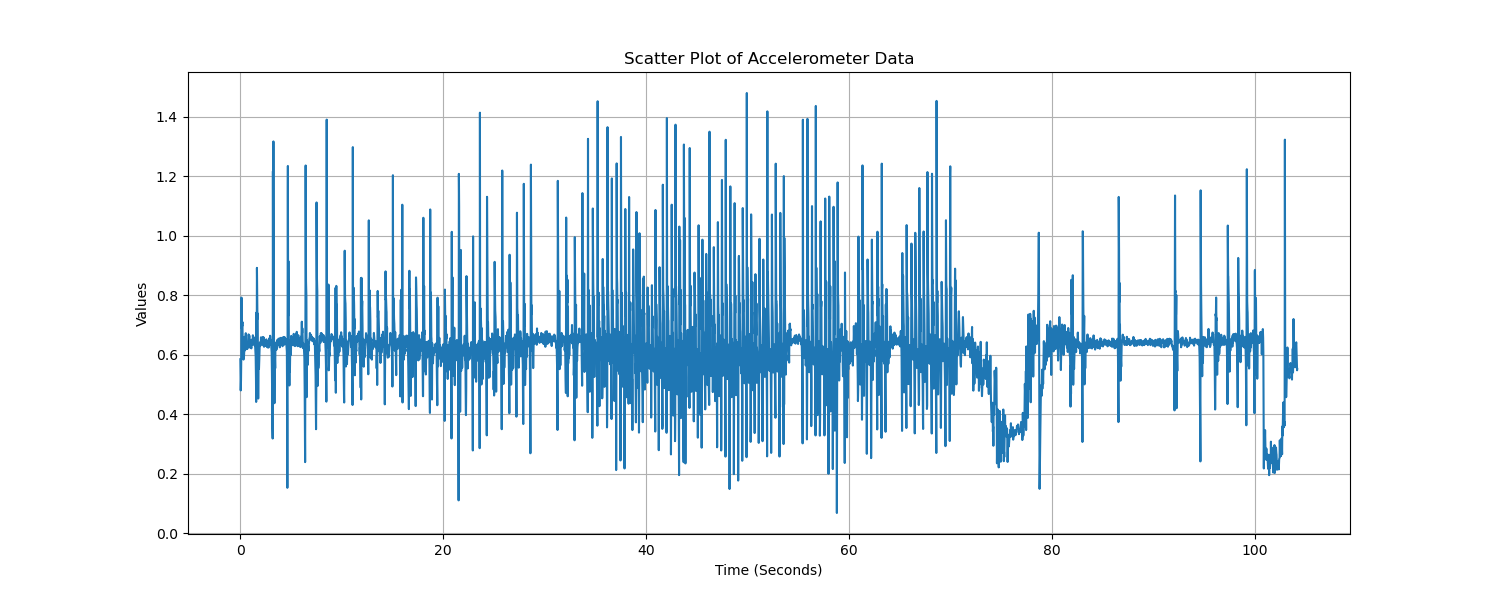

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 6))
plt.plot(df_nerve["Time"],
         df_nerve["Accelerometer"]-0.98-0.25)
# -0.98 is the offset for the accelerometer data gravity, 0.25 for general hand movement
plt.title("Scatter Plot of Accelerometer Data")
plt.xlabel("Time (Seconds)")
plt.ylabel("Values")
plt.grid(True)
#plt.xlim(0,20000)

# Show the plot
plt.show()

In [15]:
# Find when the filament makes contact = when accelerometer is 0, between two peaks.
# Find all the peaks:

df_nerve["Accelerometer"].min()

1.298346

In [65]:
from scipy.signal import find_peaks

# Filter the DataFrame to include only the rows where Time > 82
filtered_df = df_nerve[df_nerve['Time'] > 81]

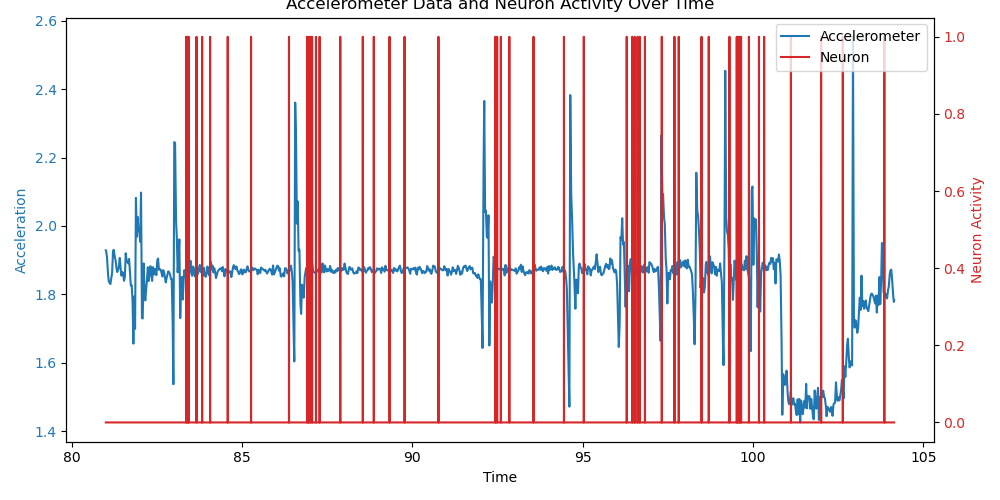

In [66]:
def plot_accelerometer_and_neuron(df_nerve, figsize=(10, 5)):
    fig, ax1 = plt.subplots(figsize=figsize)

    # Plot accelerometer data
    color = 'tab:blue'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Acceleration', color=color)
    ax1.plot(df_nerve['Time'], df_nerve['Accelerometer'], color=color, label='Accelerometer')
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis to plot neuron activity
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Neuron Activity', color=color)
    ax2.plot(df_nerve['Time'], df_nerve['Spikes'], color=color, label='Neuron')
    ax2.tick_params(axis='y', labelcolor=color)

    # Add legends
    fig.tight_layout()
    fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

    plt.title('Accelerometer Data and Neuron Activity Over Time')
    plt.show()

plot_accelerometer_and_neuron(filtered_df)

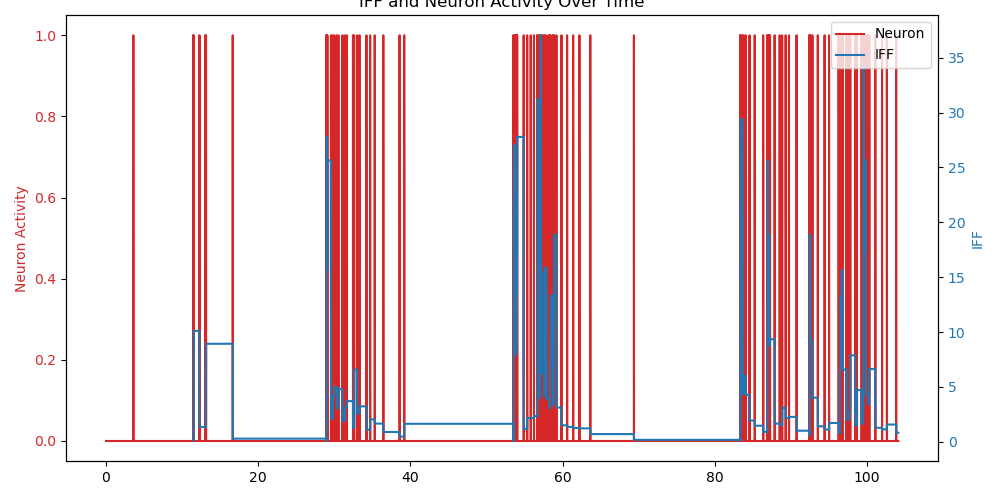

In [48]:
def plot_neuron_and_iff(df_nerve, figsize=(10, 5)):
    fig, ax1 = plt.subplots(figsize=figsize)

    color = 'tab:red'
    ax1.set_ylabel('Neuron Activity', color=color)
    ax1.plot(df_nerve['Time'], df_nerve['Spikes'], color=color, label='Neuron')
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis to plot neuron activity
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_xlabel('Time')
    ax2.set_ylabel('IFF', color=color)
    ax2.plot(df_nerve['Time'], df_nerve['IFF'], color=color, label='IFF')
    ax2.tick_params(axis='y', labelcolor=color)

    # Add legends
    fig.tight_layout()
    fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

    plt.title('IFF and Neuron Activity Over Time')
    plt.show()

plot_neuron_and_iff(df_nerve)

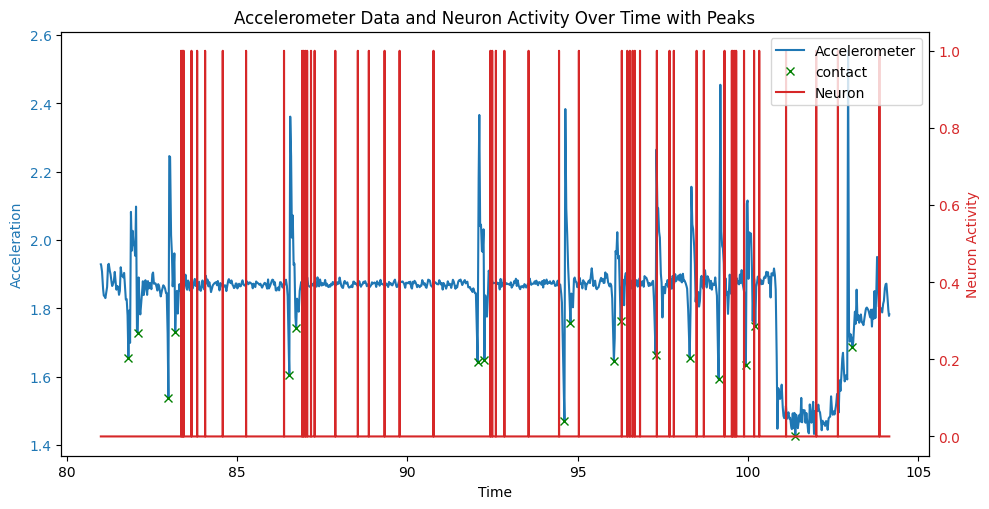

In [122]:
def plot_accelerometer_and_neuron_with_peaks(df_nerve, threshold=0.14, distance=20, figsize=(10, 5)):
    fig, ax1 = plt.subplots(figsize=figsize)

    # Plot accelerometer data
    color = 'tab:blue'
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Acceleration', color=color)
    ax1.plot(df_nerve['Time'], df_nerve['Accelerometer'], color=color, label='Accelerometer')
    ax1.tick_params(axis='y', labelcolor=color)

    # Find peaks in the accelerometer data
    peaks, _ = find_peaks(-filtered_df['Accelerometer'], prominence=0.14, distance=20)
    ax1.plot(df_nerve['Time'].iloc[peaks], df_nerve['Accelerometer'].iloc[peaks], 'x', color='green', label='contact')

    # Create a second y-axis to plot neuron activity
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Neuron Activity', color=color)
    ax2.plot(df_nerve['Time'], df_nerve['Spikes'], color=color, label='Neuron')
    ax2.tick_params(axis='y', labelcolor=color)

    # Add legends
    fig.tight_layout()
    fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

    plt.title('Accelerometer Data and Neuron Activity Over Time with Peaks')
    plt.show()

plot_accelerometer_and_neuron_with_peaks(filtered_df)

## RF Mapping

creating mock data for neuron spikes, time (sort of), and the IFF.

In [14]:
# create artificial synchronized neuron data, first starting with some real data:
# take transformed monofil tip data, bending coefficient data, and make the spikes data in a few conditions:
# 1. when bending coefficient is above a certain threshold, make spike data 1
# 2. when bending coefficient is above a certain threshold, make spike data 0
# 3. when bending coefficient is below a certain threshold, make spike data 1

df_rf_mapping = pd.concat([transformed_monofil.iloc[:, -2:], df_monofil['Bending_Coefficient']], axis=1)

# Now create the spike data on the above conditions, most should be 1 when threshold is past the certain threshold
threshold = 0.10 * df_rf_mapping['Bending_Coefficient'].max()

# Initialize the spike data column with zeros
df_rf_mapping['Neuron'] = 0

# Condition 1: When bending coefficient is above the threshold, make spike data 1 sometimes
high_bending_indices = df_rf_mapping['Bending_Coefficient'] > threshold
df_rf_mapping.loc[high_bending_indices, 'Neuron'] = np.random.choice([0, 1], size=high_bending_indices.sum(), p=[0.2, 0.8])

# Condition 2: When bending coefficient is above the threshold, make spike data 0 sometimes
# (This condition is already covered by the initialization of the spike data column with zeros)

# Condition 3: When bending coefficient is below the threshold, make spike data 1 sometimes
low_bending_indices = df_rf_mapping['Bending_Coefficient'] <= threshold
df_rf_mapping.loc[low_bending_indices, 'Neuron'] = np.random.choice([0, 1], size=low_bending_indices.sum(), p=[0.90, 0.1])

<Axes: >

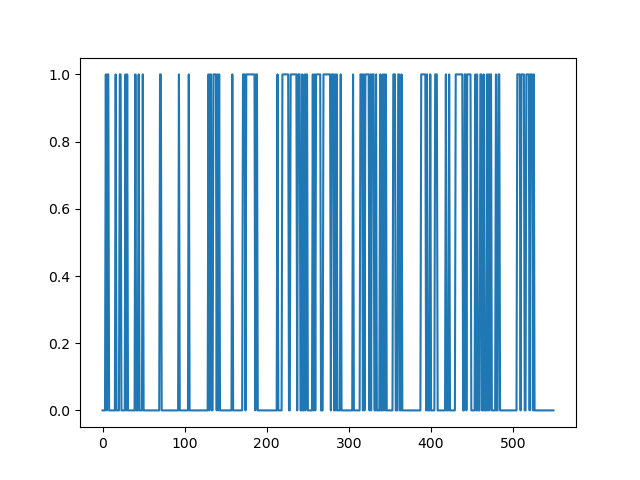

In [15]:
df_rf_mapping["Neuron"].plot()

trying some simple rf mapping using the neuron spikes relative to location and size of bending coefficient

In [16]:
%matplotlib notebook

In [21]:
import seaborn as sns
from matplotlib.lines import Line2D

def plot_rf_mapping(df, threshold=0.14, figsize=(10, 10)):
    threshold = threshold * df['Bending_Coefficient'].max()
    #! Assuming this data is synchronized

    # Filter data based on the bending coefficient and neuron activity
    high_bending_neuron_on = df[(df['Bending_Coefficient'] > threshold) & (df['Neuron'] == 1)]
    high_bending_neuron_off = df[(df['Bending_Coefficient'] > threshold) & (df['Neuron'] == 0)]
    low_bending_neuron_on = df[(df['Bending_Coefficient'] <= threshold) & (df['Neuron'] == 1)]

    # Create the plot
    plt.figure(figsize=figsize)
    alpha = 0.1

   # Plot neuron activity when bending coefficient is past the threshold and neuron is off
    sns.scatterplot(x='tf_FB2_x', y='tf_FB2_y', size='IFF', sizes=(25, 50), alpha=alpha, edgecolor=None, data=high_bending_neuron_off, color='blue')

    # Plot neuron activity when bending coefficient is past the threshold and neuron is on
    sns.scatterplot(x='tf_FB2_x', y='tf_FB2_y', size='IFF', sizes=(25, 50), alpha=alpha, edgecolor=None, data=high_bending_neuron_on, color='red')

    # Plot neuron activity when bending coefficient is not past the threshold and neuron is on
    sns.scatterplot(x='tf_FB2_x', y='tf_FB2_y', s = 50, alpha=alpha, edgecolor=None, data=low_bending_neuron_on, color='green')

    # Add legend manually for colors only
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='High Bending and Neuron On'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='High Bending and Neuron Off'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Low Bending and Neuron On')
    ]
    plt.legend(handles=legend_elements, loc='upper right')

    plt.title('RF Mapping of Neuron Activity')
    plt.xlabel('tf_FB2_x')
    plt.ylabel('tf_FB2_y')
    plt.xlim(0, 300)
    plt.ylim(0, 300)

    plt.axhline(y=100, color='k', linestyle='--', alpha=0.5)
    plt.axhline(y=200, color='k', linestyle='--', alpha=0.5)
    plt.axvline(x=100, color='k', linestyle='--', alpha=0.5)
    plt.axvline(x=200, color='k', linestyle='--', alpha=0.5)

    plt.gca().invert_yaxis()  # Invert y-axis to match image coordinates
    plt.show()

<IPython.core.display.Javascript object>

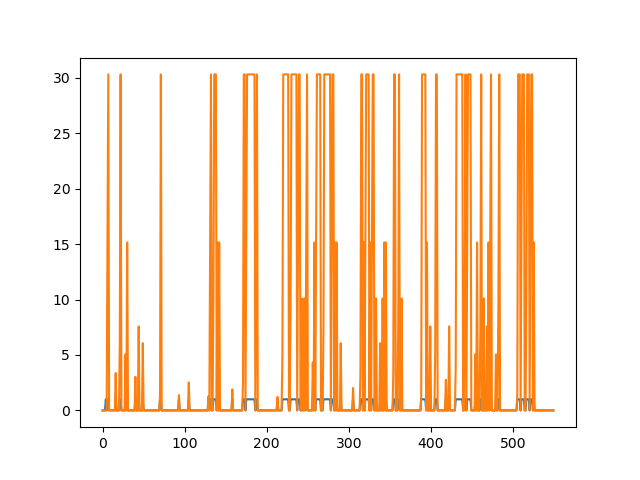

In [22]:
plot_rf_mapping(df_rf_mapping, 0.04)

Creating an animated RF mapping alternative

In [41]:
from matplotlib.animation import FuncAnimation, PillowWriter

def realtime_rf_mapping(df_rf_mapping,
                        threshold = 0.14, 
                        output_path = 'animation.gif',
                        fps = 30,
                        figsize = (10, 10)):
    threshold = threshold * df_rf_mapping['Bending_Coefficient'].max()
    fig, ax = plt.subplots(figsize = figsize)
    alpha = 0.1

    def update(frame):
        ax.clear()
        ax.set_xlim(0, 300)
        ax.set_ylim(0, 300)

        ax.axhline(y=100, color='k', linestyle='--', alpha=0.5)
        ax.axhline(y=200, color='k', linestyle='--', alpha=0.5)
        ax.axvline(x=100, color='k', linestyle='--', alpha=0.5)
        ax.axvline(x=200, color='k', linestyle='--', alpha=0.5)

        current_data = df_rf_mapping.iloc[:frame+1]
        high_bending_neuron_on = current_data[
            (current_data['Bending_Coefficient'] > threshold) &
            (current_data['Neuron'] == 1)]
        high_bending_neuron_off = current_data[
            (current_data['Bending_Coefficient'] > threshold) &
            (current_data['Neuron'] == 0)]
        low_bending_neuron_on = current_data[
            (current_data['Bending_Coefficient'] <= threshold) &
            (current_data['Neuron'] == 1)]

        sns.scatterplot(x='tf_FB2_x', y='tf_FB2_y',
                        size='Bending_Coefficient', sizes=(50, 200),
                        alpha=alpha, edgecolor=None,
                        data=high_bending_neuron_off, color='blue', ax=ax)
        sns.scatterplot(x='tf_FB2_x', y='tf_FB2_y',
                        size='Bending_Coefficient', sizes=(50, 200),
                        alpha=alpha, edgecolor=None,
                        data=high_bending_neuron_on, color='red', ax=ax)
        sns.scatterplot(x='tf_FB2_x', y='tf_FB2_y',
                        size='Bending_Coefficient', sizes=(50, 200),
                        alpha=alpha, edgecolor=None,
                        data=low_bending_neuron_on, color='green', ax=ax)

        ax.set_title('RF Mapping of Neuron Activity')
        ax.set_xlabel('tf_FB2_x')
        ax.set_ylabel('tf_FB2_y')
        ax.invert_yaxis()

        legend_elements = [
            Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=10, label='High Bending, Neuron On'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=10, label='High Bending, Neuron Off'),
            Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Low Bending, Neuron On')
        ]
        ax.legend(handles=legend_elements, loc='upper right')

    ani = FuncAnimation(fig, update, frames=len(df_rf_mapping), repeat=False)
    ani.save(output_path, writer=PillowWriter(fps=fps))
    plt.close()

In [ ]:
realtime_rf_mapping(df_rf_mapping, 0.04)

### Trying a height/contour map for IFF on location

In [19]:
# Add a time column to the DataFrame, it should be a sample rate of 30 fps
# So each increment should be 0.033 seconds

df_rf_mapping['Time'] = np.arange(0, 0.033 * len(df_rf_mapping), 0.033)

In [20]:
# 1 divided by the difference between the current time and last spike time
spikes_loc = df_rf_mapping[df_rf_mapping["Neuron"] == 1].index
spikes_loc

df_rf_mapping["IFF"] = np.nan

for i in range(1, len(spikes_loc)):
    diff = df_rf_mapping.loc[spikes_loc[i], "Time"] - df_rf_mapping.loc[spikes_loc[i - 1], "Time"] # calculate the difference between the current time and last spike time
    df_rf_mapping.loc[spikes_loc[i], "IFF"] = 1 / diff # calculate the reciprocal of the difference

#df_rf_mapping["IFF"].fillna(method='ffill', inplace=True) # fill the NaN values with the previous non-NaN value
df_rf_mapping["IFF"].fillna(0, inplace=True) # fill the remaining NaN values with 0

df_rf_mapping["IFF"].plot()

C:\Users\Gabri\AppData\Local\Temp\ipykernel_3844\2863460491.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_rf_mapping["IFF"].fillna(0, inplace=True) # fill the remaining NaN values with 0


<Axes: >

In [28]:
%matplotlib widget
# Enables interactive mode in Jupyter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from mpl_toolkits.mplot3d import Axes3D

df_thresholded = df_rf_mapping[df_rf_mapping['Bending_Coefficient'] > threshold]

x = df_thresholded['tf_FB2_x']
y = df_thresholded['tf_FB2_y']
z = df_thresholded['IFF']

In [29]:
df_thresholded['IFF'].describe()

count    167.000000
mean      18.954457
std       13.188976
min        0.000000
25%        2.849003
50%       30.303030
75%       30.303030
max       30.303030
Name: IFF, dtype: float64

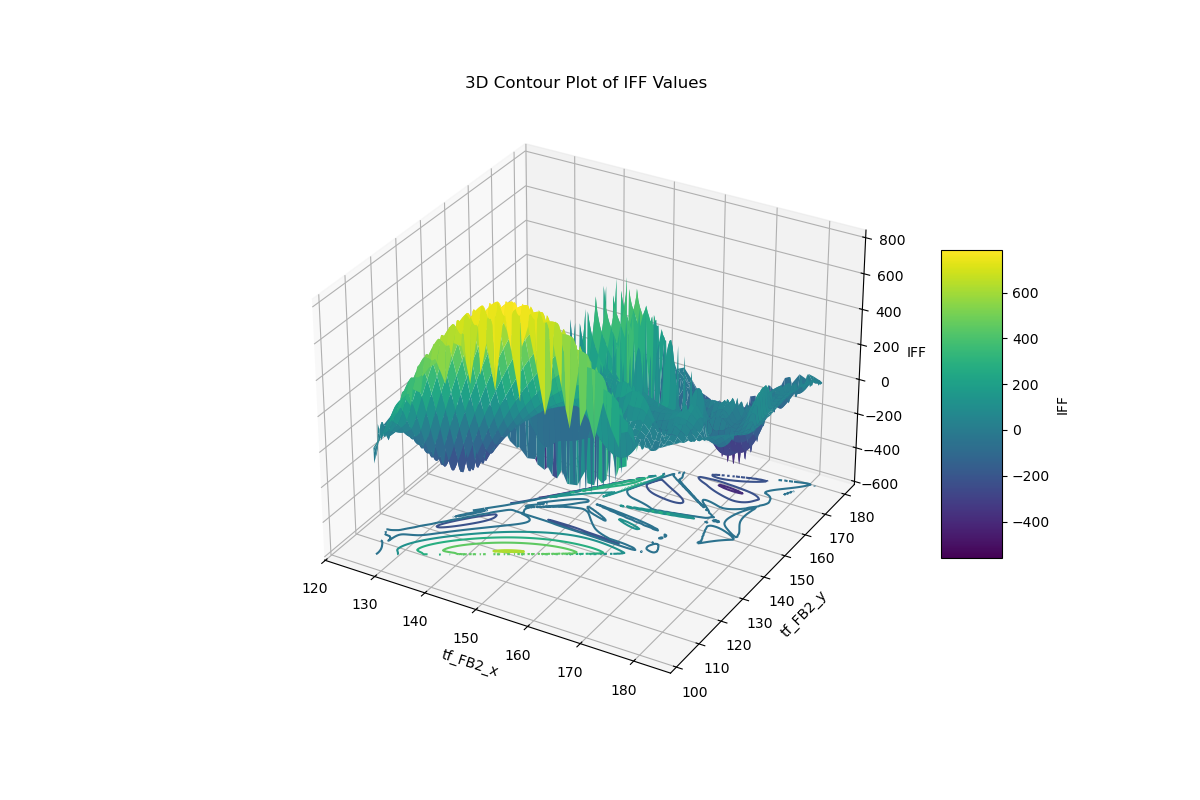

In [32]:
# Define grid
xi = np.linspace(min(x), max(x), 200)
yi = np.linspace(min(y), max(y), 200)
xi, yi = np.meshgrid(xi, yi)

# Interpolate data
zi = griddata((x, y), z, (xi, yi), method='cubic')

# Create 3D plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(xi, yi, zi, cmap='viridis', edgecolor='none')

# Add contour lines
ax.contour(xi, yi, zi, zdir='z', offset=np.nanmin(zi), cmap='viridis')

# Add color bar
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('IFF')

# Set labels and title
ax.set_xlabel('tf_FB2_x')
ax.set_ylabel('tf_FB2_y')
ax.set_zlabel('IFF')
ax.set_title('3D Contour Plot of IFF Values')

#ax.set_xlim(100,200)
#ax.set_ylim(100,200)

plt.show()  # Interactive plot should now work

C:\Users\Gabri\AppData\Local\Temp\ipykernel_3844\4287484153.py:15: UserWarning: 
The sizes list has fewer values (2) than needed (38) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x='tf_FB2_x', y='tf_FB2_y',


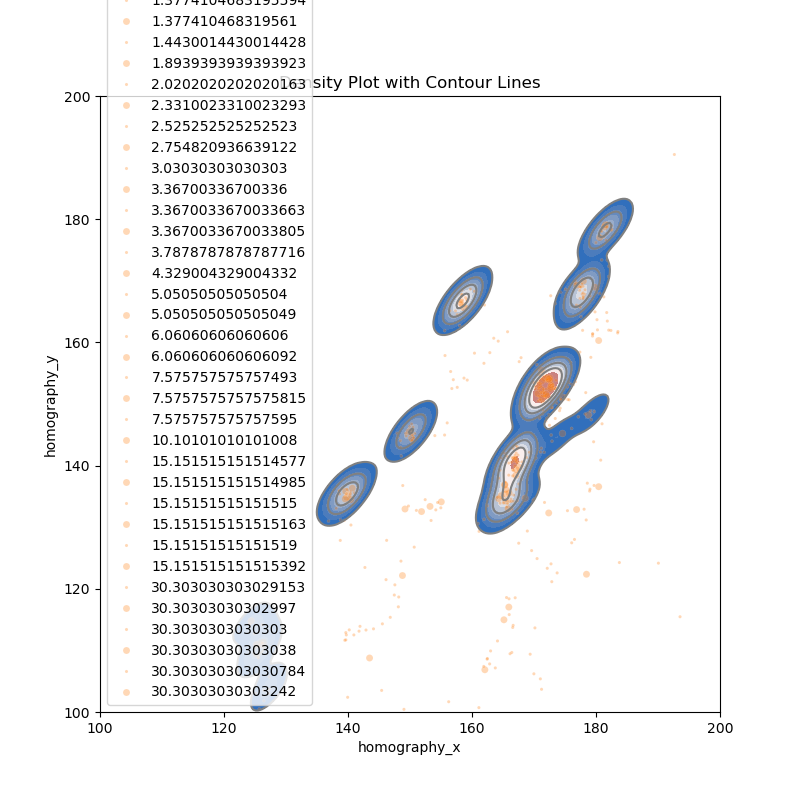

In [27]:
plt.figure(figsize=(8, 8))

# KDE with sharper peaks
sns.kdeplot(x=x, y=y, fill=True, cmap='vlag', bw_adjust=0.3)

# Add contour lines to differentiate levels
sns.kdeplot(x=x, y=y, levels=5, color='gray', bw_adjust=0.3)  # More levels = more detail

# Scatterplot with color mapped to IFF values
# sns.scatterplot(x='tf_FB2_x', y='tf_FB2_y',
#                 hue='IFF',  # Color based on IFF
#                 size=10,  # Fixed size
#                 alpha=0.5, edgecolor=None,
#                 data=df_rf_mapping, palette='vlag')  # Choose a perceptual colormap
sns.scatterplot(x='tf_FB2_x', y='tf_FB2_y',
                size='IFF',  # Color based on IFF
                sizes=[5,25],  # Fixed size
                alpha=0.3,
                data=df_rf_mapping)  # Choose a perceptual colormap

plt.xlim(100, 200)
plt.ylim(100, 200)
plt.xlabel('homography_x')
plt.ylabel('homography_y')
plt.title('Density Plot with Contour Lines')
plt.show()

---

In [9]:
'''
import cv2
import pandas as pd
import numpy as np

# Extract the metadata from the video, FPS and the total amount of frames
video_path = r"C:\Python_programming\LIA_LIU\GH010342_converted.mp4"
video = cv2.VideoCapture(video_path)
fps = video.get(cv2.CAP_PROP_FPS)
total_frames = video.get(cv2.CAP_PROP_FRAME_COUNT)
video.release()

# Load your h5 file
h5_file = r"C:\Python_programming\LIA_LIU\GH010342_convertedDLC_Resnet101_test_10_000_epochsOct28shuffle1_snapshot_1425.h5"
df = pd.read_hdf(h5_file)

# Renaming columns and remove 'scorer' level
df.columns = [f"{bodypart}_{coord}" for bodypart, coord in zip(df.columns.get_level_values(1), df.columns.get_level_values(2))]

# Add 'time' column to represent timestamp in seconds
df['time'] = np.arange(len(df)) / fps

# Display the first few rows to verify
df.tail()
'''

'\nimport cv2\nimport pandas as pd\nimport numpy as np\n\n# Extract the metadata from the video, FPS and the total amount of frames\nvideo_path = r"C:\\Python_programming\\LIA_LIU\\GH010342_converted.mp4"\nvideo = cv2.VideoCapture(video_path)\nfps = video.get(cv2.CAP_PROP_FPS)\ntotal_frames = video.get(cv2.CAP_PROP_FRAME_COUNT)\nvideo.release()\n\n# Load your h5 file\nh5_file = r"C:\\Python_programming\\LIA_LIU\\GH010342_convertedDLC_Resnet101_test_10_000_epochsOct28shuffle1_snapshot_1425.h5"\ndf = pd.read_hdf(h5_file)\n\n# Renaming columns and remove \'scorer\' level\ndf.columns = [f"{bodypart}_{coord}" for bodypart, coord in zip(df.columns.get_level_values(1), df.columns.get_level_values(2))]\n\n# Add \'time\' column to represent timestamp in seconds\ndf[\'time\'] = np.arange(len(df)) / fps\n\n# Display the first few rows to verify\ndf.tail()\n'

Extract the relevent data from the nerv file

Split DataFrame in 3 sub DF's , monofilament, square and likelihood

In [11]:
'''
# Sub-DataFrame 1: df_monofil for FR, FG, and FB columns
df_monofil = df.loc[:, df.columns.str.startswith(('FR', 'FG', 'FB'))\
                    & ~df.columns.str.endswith('likelihood')]

# Sub-DataFrame 2: df_square for Top_left, Top_right, Bottom_left, Bottom_right columns
df_square = df.loc[:, df.columns.str.startswith(('Top_left',
                                                 'Top_right',
                                                 'Bottom_left',
                                                 'Bottom_right'))\
                    & ~df.columns.str.endswith('likelihood')]

# Sub-DataFrame 3: df_likelihoods for all likelihood columns
df_likelihoods = df.loc[:, df.columns.str.endswith('likelihood')]

# Display the first few rows of each to verify
print("Monofilament DataFrame:\n", df_monofil.head())
print("\nSquare DataFrame:\n", df_square.head())
print("\nLikelihoods DataFrame:\n", df_likelihoods.head())
'''

'\n# Sub-DataFrame 1: df_monofil for FR, FG, and FB columns\ndf_monofil = df.loc[:, df.columns.str.startswith((\'FR\', \'FG\', \'FB\'))                    & ~df.columns.str.endswith(\'likelihood\')]\n\n# Sub-DataFrame 2: df_square for Top_left, Top_right, Bottom_left, Bottom_right columns\ndf_square = df.loc[:, df.columns.str.startswith((\'Top_left\',\n                                                 \'Top_right\',\n                                                 \'Bottom_left\',\n                                                 \'Bottom_right\'))                    & ~df.columns.str.endswith(\'likelihood\')]\n\n# Sub-DataFrame 3: df_likelihoods for all likelihood columns\ndf_likelihoods = df.loc[:, df.columns.str.endswith(\'likelihood\')]\n\n# Display the first few rows of each to verify\nprint("Monofilament DataFrame:\n", df_monofil.head())\nprint("\nSquare DataFrame:\n", df_square.head())\nprint("\nLikelihoods DataFrame:\n", df_likelihoods.head())\n'

In [12]:
def print_likelihood_averages(df_likelihoods):
    averages = df_likelihoods.mean()  # Calculate the mean for each column (body part)
    for body_part, avg in averages.items():
        print(f"Average likelihood for {body_part}: {avg:.4f}")
print_likelihood_averages(df_likelihoods)

Average likelihood for FR1_likelihood: 0.8959
Average likelihood for FR2_likelihood: 0.8960
Average likelihood for FG1_likelihood: 0.9175
Average likelihood for FG2_likelihood: 0.9319
Average likelihood for FB1_likelihood: 0.9913
Average likelihood for FB2_likelihood: 0.9960
Average likelihood for Top_left_likelihood: 0.9388
Average likelihood for Top_right_likelihood: 0.8673
Average likelihood for Bottom_left_likelihood: 0.6813
Average likelihood for Bottom_right_likelihood: 0.7296


In [13]:
df_square.isnull().sum()

Top_left_x        0
Top_left_y        0
Top_right_x       0
Top_right_y       0
Bottom_left_x     0
Bottom_left_y     0
Bottom_right_x    0
Bottom_right_y    0
dtype: int64

In [14]:
df_square.head()

,Top_left_x,Top_left_y,Top_right_x,Top_right_y,Bottom_left_x,Bottom_left_y,Bottom_right_x,Bottom_right_y
0,607.893005,370.872986,622.898987,301.819000,452.752991,561.775024,684.257019,228.453003
1,479.050995,462.619995,588.431030,465.640991,455.720001,563.854980,707.760986,402.803009
2,609.025024,370.217987,589.073975,466.115997,453.239014,561.559998,707.995972,401.384003
3,610.382019,369.791992,590.640015,464.601013,455.459015,563.239014,563.200012,566.288025
4,484.294006,460.196014,591.546997,463.634003,459.066010,563.254028,564.474976,565.926025


Apply homography, creates df_square_corrected nand df_monofil_corrected

In [15]:
import numpy as np
import pandas as pd
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac

def apply_homography(df_monofil, df_square, segment_length_mm=20):
    """
    Applies homography transformation to the provided monofilament and square points.
    
    Parameters:
        df_monofil (pd.DataFrame): DataFrame with raw monofilament points (x, y).
        df_square (pd.DataFrame): DataFrame with raw square points (x, y).
        segment_length_mm (float): Length of the square segment in millimeters for target corners.
        
    Returns:
        pd.DataFrame: DataFrames with corrected monofilament and square points.
    """
    # Initialize variables
    trackingpoints = {}
    trackingpoints['nframes'] = df_monofil.shape[0]
    trackingpoints['nfilpoints'] = int(df_monofil.shape[1] / 2)  # each point has x, y
    trackingpoints['nsquarepoints'] = int(df_square.shape[1] / 2)  # each point has x, y

    # Prepare raw arrays for monofilament and square points
    monofilament = {'raw': np.zeros((trackingpoints['nframes'], trackingpoints['nfilpoints'], 2))}
    square = {'raw': np.zeros((trackingpoints['nframes'], trackingpoints['nsquarepoints'], 2))}

    # Populate raw arrays for monofilament and square points
    for i in range(trackingpoints['nfilpoints']):
        monofilament['raw'][:, i, :] = df_monofil.iloc[:, [i*2, i*2 + 1]].to_numpy()

    for i in range(trackingpoints['nsquarepoints']):
        square['raw'][:, i, :] = df_square.iloc[:, [i*2, i*2 + 1]].to_numpy()

    # Homography setup
    monofilament['corrected'] = np.zeros((trackingpoints['nframes'], trackingpoints['nfilpoints'], 2))
    square['corrected'] = np.zeros((trackingpoints['nframes'], trackingpoints['nsquarepoints'], 2))

    # Define target corners for square points (representing real-world dimensions)
    target_corners = {
        'x': [0, 0, segment_length_mm, segment_length_mm],
        'y': [0, segment_length_mm, 0, segment_length_mm]
    }
    target_corners_xy = np.column_stack((target_corners['x'], target_corners['y']))

    # Perform homography transformation on each frame
    for t in range(trackingpoints['nframes']):

        corners = square['raw'][t, :, :]
        filament = monofilament['raw'][t, :, :]

        # Fit projective transform (homography) using RANSAC
        model_robust, _ = ransac(
            (corners, target_corners_xy),
            ProjectiveTransform,
            min_samples=4,
            residual_threshold=2,
            max_trials=1000
        )

        # Apply the transformation to square and monofilament points
        square['corrected'][t, :, :] = model_robust(corners)
        monofilament['corrected'][t, :, :] = model_robust(filament)

    # Convert corrected points back into DataFrames with original names + "_corr"
    df_square_corrected = pd.DataFrame(
        square['corrected'].reshape(-1, trackingpoints['nsquarepoints'] * 2),
        columns=[f"{col}_corr" for col in df_square.columns]
    )

    df_monofil_corrected = pd.DataFrame(
        monofilament['corrected'].reshape(-1, trackingpoints['nfilpoints'] * 2),
        columns=[f"{col}_corr" for col in df_monofil.columns]
    )

    print("Homography transformation complete.")
    
    return df_monofil_corrected, df_square_corrected

# Call the function
df_monofil_corrected, df_square_corrected = apply_homography(df_monofil, df_square)

# Print the resulting DataFrames to check
print(df_monofil_corrected.head())
print(df_square_corrected.head())

Homography transformation complete.
   FR1_x_corr  FR1_y_corr  FR2_x_corr  FR2_y_corr  FG1_x_corr  FG1_y_corr  \
0   -1.610395    8.697412   -1.879602    9.164702   -1.890665    9.639184   
1    5.864859    0.753756    5.826240    0.832174    5.824793    0.905298   
2   -0.227053   -1.475424   -0.192289   -1.333634   -0.158186   -1.242304   
3   10.677745   -4.594941    8.578496   -4.886354    6.673463   -5.126548   
4  -41.074973   16.024821  -37.404345   16.942638  -35.503062   17.504852   

   FG2_x_corr  FG2_y_corr  FB1_x_corr  FB1_y_corr  FB2_x_corr  FB2_y_corr  
0   -2.307664    9.998222   -2.957986   10.717325   -4.425774   12.049140  
1    5.770399    0.952186    5.687447    1.028118    5.545746    1.067846  
2   -0.222189   -1.206533   -0.289262   -1.132742   -0.353250   -1.003293  
3    9.336606   -3.950709   10.289353   -3.180553   11.877289   -2.364832  
4  -32.909856   17.167849  -29.754121   16.877099  -26.090482   16.659951  
   Top_left_x_corr  Top_left_y_corr  Top_righ

Plot the coordinates from before and after homography

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_tracking_results(df_monofil, df_square, df_monofil_corrected, df_square_corrected, num_frames_to_plot=10):
    """
    Plots the raw and corrected points for the square and monofilament in the specified number of frames.
    
    Parameters:
        df_monofil (DataFrame): Raw monofilament points (before homography).
        df_square (DataFrame): Raw square points (before homography).
        df_monofil_corrected (DataFrame): Corrected monofilament points (after homography).
        df_square_corrected (DataFrame): Corrected square points (after homography).
        num_frames_to_plot (int): Number of frames to display. Default is 5.
    """
    # Convert DataFrames to numpy arrays
    raw_square = df_square.to_numpy().reshape(-1, df_square.shape[1] // 2, 2)
    corrected_square = df_square_corrected.to_numpy().reshape(-1, df_square_corrected.shape[1] // 2, 2)
    raw_monofil = df_monofil.to_numpy().reshape(-1, df_monofil.shape[1] // 2, 2)
    corrected_monofil = df_monofil_corrected.to_numpy().reshape(-1, df_monofil_corrected.shape[1] // 2, 2)

    # Number of frames to plot (ensure we don't exceed available frames)
    num_frames_to_plot = min(num_frames_to_plot, raw_square.shape[0])

    # Set up the figure and axis for the plots
    fig, axes = plt.subplots(num_frames_to_plot, 2, figsize=(10, 5 * num_frames_to_plot))

    # Loop through frames
    for t in range(num_frames_to_plot):
        # Extract raw and corrected points for current frame
        raw_square_points = raw_square[t, :, :]
        corrected_square_points = corrected_square[t, :, :]
        raw_monofil_points = raw_monofil[t, :, :]
        corrected_monofil_points = corrected_monofil[t, :, :]

        # Plot raw (before homography)
        ax1 = axes[t, 0]
        ax1.scatter(raw_square_points[:, 0], raw_square_points[:, 1], color='blue', label="Square Points")
        ax1.scatter(raw_monofil_points[:, 0], raw_monofil_points[:, 1], color='red', label="Monofilament Points")
        ax1.set_title(f"Frame {t + 1} - Before Homography")
        ax1.set_xlabel("X")
        ax1.set_ylabel("Y")
        ax1.legend()
        ax1.invert_yaxis()  # Invert Y to match the coordinate system
        ax1.set_xlim(300, 1200)  
        ax1.set_ylim(0, 900)

        # Plot corrected (after homography)
        ax2 = axes[t, 1]
        ax2.scatter(corrected_square_points[:, 0], corrected_square_points[:, 1], color='blue', label="Square Points")
        ax2.scatter(corrected_monofil_points[:, 0], corrected_monofil_points[:, 1], color='red', label="Monofilament Points")
        ax2.set_title(f"Frame {t + 1} - After Homography")
        ax2.set_xlabel("X")
        ax2.set_ylabel("Y")
        ax2.legend()
        ax2.invert_yaxis()  # Invert Y to match the coordinate system
        ax2.set_xlim(-40, 60)  
        ax2.set_ylim(-40, 60)

    # Adjust layout for clarity
    plt.tight_layout()
    plt.show()


plot_tracking_results(df_monofil, df_square, df_monofil_corrected, df_square_corrected)




Find the frames with contact using angular calculation

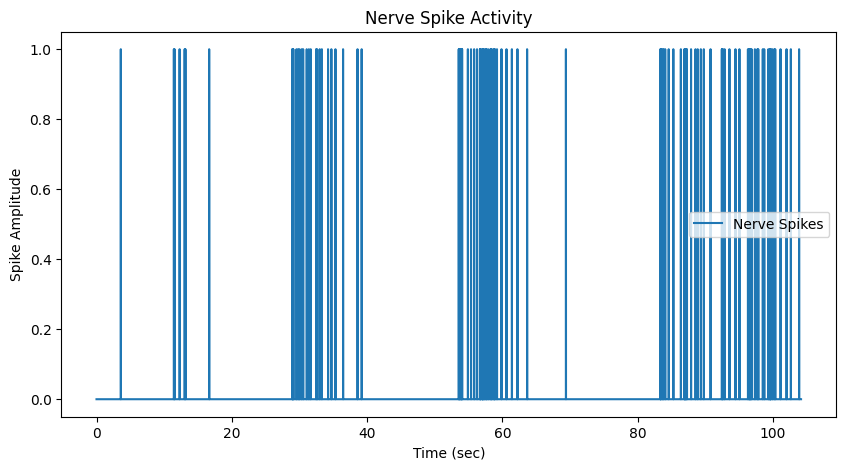

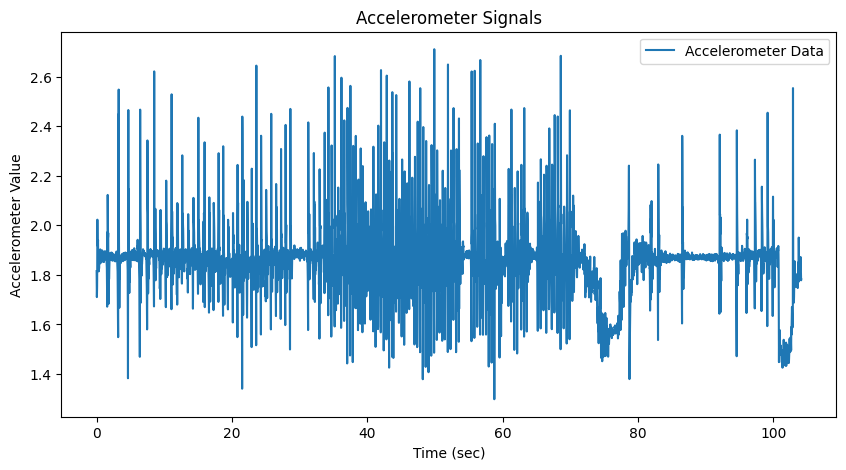

In [16]:
import pandas as pd
import numpy as np

# Clean the DataFrame
df_nerve_cleaned = df_nerve.dropna(subset=['Time', '5 Accelerometer'])  # Drop rows with missing Time or Accelerometer data

# Map to mng dictionary
mng = {
    'time_sec': df_nerve_cleaned['Time'].to_numpy(),  # Time in seconds
    'spikes': df_nerve_cleaned['Spikes nw-1-01'].to_numpy(),  # Nerve spikes
    'accelerometer': df_nerve_cleaned['5 Accelerometer'].to_numpy(),  # Accelerometer data
}

# Example: Plot spikes
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(mng['time_sec'], mng['spikes'], label='Nerve Spikes')
plt.xlabel('Time (sec)')
plt.ylabel('Spike Amplitude')
plt.title('Nerve Spike Activity')
plt.legend()
plt.show()

# Example: Plot accelerometer data
plt.figure(figsize=(10, 5))
plt.plot(mng['time_sec'], mng['accelerometer'], label='Accelerometer Data')
plt.xlabel('Time (sec)')
plt.ylabel('Accelerometer Value')
plt.title('Accelerometer Signals')
plt.legend()
plt.show()



In [5]:
import scipy.io

import scipy.io

# Load the MATLAB file
mat_file_path = r'C:\Python Programming\LIU\matlab files\Unit_27_Zoom_97_ST14-01.mat'
mat_data = scipy.io.loadmat(mat_file_path)

# Access the variables in the MATLAB file
print(mat_data.keys())  # List all variables in the file


dict_keys(['__header__', '__version__', '__globals__', 'S', '__function_workspace__'])


In [8]:
print(mat_data)  # Display the shape of the 'data' variable

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Aug 15 16:40:18 2022', '__version__': '1.0', '__globals__': [], 'S': array([[(array([[14]], dtype=uint8), array([[1]], dtype=uint8), array([[97]], dtype=uint8), array(['ST14-01'], dtype='<U7'), array([[27]], dtype=uint8), array([[68]], dtype=uint8), array(['SAI'], dtype='<U3'), array(['RF_mapping'], dtype='<U10'), array([[(array([[(MatlabOpaque([(b'', b'MCOS', b'table', array([[3707764736],
                                             [         2],
                                             [         1],
                                             [         1],
                                             [         1],
                                             [         1]], dtype=uint32))         ],
                                     dtype=[('s0', 'O'), ('s1', 'O'), ('s2', 'O'), ('arr', 'O')]),)]],
                      dtype=[('D', 'O')]), array([[1]], dtype=uint8))                                 ]],
  

In [ ]:
variable_name = 'your_variable_name'
data = mat_data[variable_name]

print(data)